<a href="https://colab.research.google.com/github/Yanboding/MCIScheduling/blob/main/MCIScheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as RNG
from scipy.special import gamma
from pprint import pprint

In [ ]:
def getInsertionIndex(element, elements, key=lambda x: x):
    low = 0
    high = len(elements) - 1
    while low <= high:
        mid = (low + high)//2
        if key(elements[mid]) == key(element):
            # if there are duplicates in the list
            if mid + 1 < len(elements) and key(elements[mid+1]) == key(element):
                low = mid + 1
            else:
                return mid + 1
        elif key(elements[mid]) < key(element):
            low = mid + 1
        else:
            high = mid - 1
    return low

class EventNotice:

    def __init__(self, eventType, eventTime, eventObject):
        self.eventType = eventType
        self.eventTime = eventTime
        self.eventObject = eventObject

class EventCalendar:

    def __init__(self):
        self.clock = 0
        self.calendar = []

    def add(self, addedEvent):
        self.calendar.insert(getInsertionIndex(addedEvent, self.calendar, key=lambda x: x.eventTime),addedEvent)

    def remove(self):
        if len(self.calendar) > 0:
            nextEvent = self.calendar.pop(0)
            self.clock = nextEvent.eventTime
            return nextEvent

    def __len__(self):
        return len(self.calendar)

class Node:

    def __init__(self, val):
        self.val = val
        self.prev = None
        self.next = None

    def isOrphan(self):
        return self.prev == None and self.next == None

class LinkedList:

    def __init__(self):
            self.head = Node(None)  # Dummy head
            self.tail = Node(None)  # Dummy tail
            self.head.next = self.tail
            self.tail.prev = self.head
            self.count = 0

    def is_empty(self):
        return self.head.next == self.tail

    def add_front(self, new_node):
        new_node.next = self.head.next
        new_node.prev = self.head
        self.head.next.prev = new_node
        self.head.next = new_node
        self.count += 1

    def add_back(self, new_node):
        new_node.next = self.tail
        new_node.prev = self.tail.prev
        self.tail.prev.next = new_node
        self.tail.prev = new_node
        self.count += 1

    def remove_front(self):
        if self.is_empty():
            return None
        front_node = self.head.next
        self.head.next = front_node.next
        front_node.next.prev = self.head
        front_node.next = front_node.prev = None
        self.count -= 1
        return front_node

    def remove_back(self):
        if self.is_empty():
            return None
        back_node = self.tail.prev
        self.tail.prev = back_node.prev
        back_node.prev.next = self.tail
        back_node.next = back_node.prev = None
        self.count -= 1
        return back_node

    def remove(self, node):
        node.prev.next = node.next
        node.next.prev = node.prev
        node.next = node.prev = None
        self.count -= 1

    def __len__(self):
        return self.count

    def display(self):
        current = self.head.next
        while current != self.tail:
            print(current.val, end=' ')
            current = current.next
        print()

class TimeStat:

    def __init__(self):
        self.times = []

    def record(self, time):
        if self.times == [] or self.times[-1] <= time:
            self.times.append(time)
        elif self.times[0] > time:
            self.times.insert(0, time)
        else:
            self.times.insert(getInsertionIndex(time, self.times), time)

class PatientStat:

    def __init__(self):
        self.patients = []

    def record(self, patient):
        i = getInsertionIndex(patient, self.patients, key=lambda p: (p.leaveTime, p.additionalInfo['id']))
        self.patients.insert(i, patient)

    def __str__(self):
        res = ''
        for patient in self.patients:
            res += str(patient.additionalInfo['id']) + ', ' + str(round(patient.leaveTime, 4)) + ', ' + str('abandon' if patient.isAbandon else 'finish') + '\n'
        return '[' + res[:-1] + ']'

    def __len__(self):
        return len(self.patients)

class MCI:

    def __init__(self, patients):
        self.patients = patients
        self.numberOfPatients = len(patients)
        self.calendar = EventCalendar()
        self.abandonTimeStat = TimeStat()
        self.survivalRate = np.vectorize(self._survivalRateFun, otypes=[float])

    def _survivalRateFun(self, t):
        numberOfDeath = getInsertionIndex(t, self.abandonTimeStat.times)
        return (self.numberOfPatients - numberOfDeath) / self.numberOfPatients

    def recordDeath(self, patientId):
        self.recordLeaveTime(patientId)
        self.patients.at[patientId, 'isAbandon'] = True
        self.abandonTimeStat.record(self.patients.at[patientId, 'leaveTime'])

    def recordLeaveTime(self, patientId):
        raise NotImplemented

class Agent:

    def __init__(self, env):
        self.env = env

    def policy(self, state):
        pass

    def strategy(self, state):
        pass

In [ ]:
class PatientGenerator:

    def __init__(self, classProbs, subclassProbs, notBeneficiaryProbs, impatientAverages, imagingAverages, imagingStds, surgeryAverages, surgeryStds, seed):
        self.classProbs = classProbs
        self.subclassProbs = subclassProbs
        self.notBeneficiaryProbs = notBeneficiaryProbs
        self.impatientAverages = impatientAverages
        self.imagingAverages = imagingAverages
        self.imagingStds = imagingStds
        self.surgeryAverages = surgeryAverages
        self.surgeryStds = surgeryStds

        self.classNumber = len(classProbs)
        self.subclassNumbers = [len(subclassProb) for subclassProb in subclassProbs]
        self.classAverageSurvivalTimes = [sum(prob*average for prob, average in zip(probs, averages)) for probs, averages in zip(subclassProbs, impatientAverages)]

        self.seed = seed
        # 1. patient class generator
        self.patientClassGenerator = np.random.default_rng(seed)
        # 2. patient subclass generator
        self.subclassGenerators = [np.random.default_rng(self.nextSeed()) for i in range(self.classNumber)]
        # 3. beneficiary generator
        self.beneficiaryGenerator = np.random.default_rng(self.nextSeed())
        # 4. impatient time generators
        self.impatientTimeGenerators = []
        for i in range(len(impatientAverages)):
            self.impatientTimeGenerators.append([])
            for j in range(len(impatientAverages[i])):
                impatientTimeGenerator = RNG.weibull_min(c=1.5, scale=impatientAverages[i][j]/gamma(1+1/1.5))
                impatientTimeGenerator.random_state = np.random.RandomState(seed=self.nextSeed())
                self.impatientTimeGenerators[i].append(impatientTimeGenerator)
        # 5. imaging time generator
        self.potentialImagingTimeGenerators = []
        for ctTime, ctStd in zip(imagingAverages, imagingStds):
            potentialImagingTimeGenerator = RNG.norm(loc=ctTime, scale=ctStd)
            potentialImagingTimeGenerator.random_state = np.random.RandomState(seed=self.nextSeed())
            self.potentialImagingTimeGenerators.append(potentialImagingTimeGenerator)
        # 6. surgery time
        self.potentialSurgeryTimeGenerators = []
        for averageSurgeryTime, surgeryTimeStd in zip(surgeryAverages, surgeryStds):
            sigma = np.sqrt(np.log(1 + (surgeryTimeStd**2 / averageSurgeryTime**2)))
            potentialSurgeryTimeGenerator = RNG.lognorm(s=sigma,scale=np.exp(np.log(averageSurgeryTime) - sigma**2/2))
            potentialSurgeryTimeGenerator.random_state = np.random.RandomState(seed=self.nextSeed())
            self.potentialSurgeryTimeGenerators.append(potentialSurgeryTimeGenerator)

    def nextSeed(self):
        self.seed += 1
        return self.seed

    def _rv(self):
        patientClass = self.patientClassGenerator.choice(np.arange(self.classNumber), p=self.classProbs)
        patientSubclass = self.subclassGenerators[patientClass].choice(np.arange(self.subclassNumbers[patientClass]), p=self.subclassProbs[patientClass])
        isSurgeryBeneficiary = self.beneficiaryGenerator.choice([False, True], p=[self.notBeneficiaryProbs[patientClass], 1-self.notBeneficiaryProbs[patientClass]])
        interarrivalTime = 0
        impatientTime = self.impatientTimeGenerators[patientClass][patientSubclass].rvs()
        potentialImagingTime = self.potentialImagingTimeGenerators[patientClass].rvs()
        potentialSurgeryTime = self.potentialSurgeryTimeGenerators[patientClass].rvs()
        classAverageSurvivalTime = self.classAverageSurvivalTimes[patientClass]
        subclassAverageSurvivalTime = self.impatientAverages[patientClass][patientSubclass]
        return [interarrivalTime, impatientTime, potentialImagingTime, potentialSurgeryTime, isSurgeryBeneficiary, patientClass, patientSubclass, classAverageSurvivalTime, subclassAverageSurvivalTime]



    def rvs(self, size):
        patients = [self._rv() for i in range(size)]
        return pd.DataFrame(patients,
                        columns=['interarrivalTime', 'impatientTime', 'potentialImagingTime', 'potentialSurgeryTime', 'isSurgeryBeneficiary', 'patientClass', 'patientSubclass', 'classAverageSurvivalTime', 'subclassAverageSurvivalTime'])

In [ ]:
import time
from pathlib import Path
def set_fontsize(ax, size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

def performanceStatPlot(performanceStat):
    keys = list(performanceStat.keys())
    t = np.arange(performanceStat[keys[0]]['expectSurvivalRate'].shape[0])
    fig, ax = plt.subplots(1,1,figsize=(20, 10))
    ax.set_xlabel("time")
    ax.set_ylabel("Survival Rate")

    for key in keys:
        ax.plot(t, performanceStat[key]['expectSurvivalRate'], '--', label=key)
        ax.fill_between(t, (performanceStat[key]['expectSurvivalRate'] - performanceStat[key]['survivalRateHalfWindow']), (performanceStat[key]['expectSurvivalRate'] + performanceStat[key]['survivalRateHalfWindow']), alpha=.1)
    set_fontsize(ax, 20)
    plt.legend(fontsize=13)
    plt.show()

def simulation(EnvClass, AgentClass, parameterFun):
    simulationParameter = parameterFun()
    patientGenerator = simulationParameter['patientGenerator']
    patientNumber = simulationParameter['patientNumber']
    subClassNumbers = simulationParameter['subClassNumbers']
    ctRoomNumber = simulationParameter['ctRoomNumber']
    orRoomNumber = simulationParameter['orRoomNumber']
    replicationNumber = simulationParameter['replicationNumber']
    t = simulationParameter['t']

    expectSurvivalRate = np.zeros_like(t)
    survivalRateSum = np.zeros_like(t)

    for i in range(replicationNumber):
        # 1. generate patients, subClassNumbers, ctRoomNumber, orRoomNumber
        patients = patientGenerator.rvs(size=patientNumber)
        mciModel =  EnvClass(patients, subClassNumbers, ctRoomNumber, orRoomNumber)
        agent = AgentClass(mciModel)
        filepath = Path('./input/input_'+str(i)+'.csv')
        filepath.parent.mkdir(parents=True, exist_ok=True)
        patients.to_csv(filepath)
        # 2. simulate
        state = mciModel.reset()
        done = False
        info = {'where': {'CT','OR'}}
        while not done:
            action = agent.chooseAction(state, info)
            state, reward, done, info = mciModel.step(action)
        survivalRateSamplePath = mciModel.survivalRate(t)
        survivalRateDiff = survivalRateSamplePath - expectSurvivalRate
        expectSurvivalRate += survivalRateDiff/(i+1)
        survivalRateSum += survivalRateDiff*(survivalRateSamplePath - expectSurvivalRate)
    survivalRateSampleVariance = np.zeros_like(t)
    survivalRateHalfWindow = np.zeros_like(t)
    if replicationNumber > 1:
        survivalRateSampleVariance = survivalRateSum/(replicationNumber-1)
        survivalRateStd = np.sqrt(survivalRateSampleVariance)
        survivalRateHalfWindow = 1.96 * survivalRateStd/np.sqrt(replicationNumber)

    return {
         'expectSurvivalRate': expectSurvivalRate,
         'survivalRateHalfWindow':survivalRateHalfWindow,
         'survivalRateSampleVariance': survivalRateSampleVariance,
         'sampleSize': replicationNumber,
         }

Ordinal triage policy: utilize CT (while avoiding OR idleness) according to a static priority based on customer class; prioritize the class (including sub-classes identified by CT) with shorter mean remaining survival time, unless the survival time is deemed too short for patients of that class to survive the surgery.

How do we compare the survival times of patients who finished imaging to those waiting for imaging? Do we consider patients who are waiting for imaging as a different class?

Yes, for those patients we have a high-variance survival distribution. We can think about more sophisticated policies but for now we can just prioritize based on mean remaining survival time (ignoring variance).

In [ ]:
class OrdinalTriageAgent(Agent):

    def __init__(self, env, threshold=103):
        super().__init__(env)
        self.threshold = threshold

    def chooseAction(self, state, info=None):
        # sorted [id, averageSurvivalTime, currentResource] sort based on (averageSurvivalTime, currentResource)
        # currentResource rule: None > CT > OR
        # select state.index as patientId, subclassAverageSurvivalTime as averageSurvivalTime, currentResource
        # from state
        # where currentQueue != 0 and isUsedORroom = False
        # union
        # select state.index as patientId, classAverageSurvivalTime as averageSurvivalTime, currentResource
        # from state
        # where currentQueue = 0 and isUsedORroom = False
        resourceRank = {None: 0, 'CT': 1, 'OR':2}
        patients = state.reset_index()
        patients['rank'] = patients['currentResource'].apply(lambda a: resourceRank[a])
        imagedPatients = patients[(patients['currentQueue'] != 0) & (patients['isUsedORroom']==False) & (patients['leaveTime'].isnull())][['index', 'subclassAverageSurvivalTime', 'currentResource','rank']]\
        .rename(columns={"index": "patientId",
                         "subclassAverageSurvivalTime": "averageSurvivalTime"})
        noimagingPatients = patients[(patients['currentQueue'] == 0) & (patients['isUsedORroom']==False) & (patients['leaveTime'].isnull())][['index', 'classAverageSurvivalTime', 'currentResource','rank']]\
        .rename(columns={"index": "patientId",
                         "classAverageSurvivalTime": "averageSurvivalTime"})
        decisionSpace = pd.concat([imagedPatients, noimagingPatients])
        savableMask = decisionSpace['averageSurvivalTime'] > self.threshold
        unsavableMask = ~savableMask
        saveable = decisionSpace[savableMask].sort_values(by=['averageSurvivalTime', 'rank'])
        unsavable = decisionSpace[unsavableMask].sort_values(by=['averageSurvivalTime', 'rank'])
        sortedDecisionSpace = pd.concat([saveable, unsavable])
        orPatientIds = sortedDecisionSpace[:(self.env.orRoomNumber - len(self.env.busyORrooms))]\
        .index
        ctPatientIds = noimagingPatients[(~noimagingPatients['patientId'].isin(orPatientIds))&(noimagingPatients['currentResource'].isnull())]\
        .sort_values(by=['averageSurvivalTime'])[:(self.env.ctRoomNumber - len(self.env.busyCTRooms))]\
        .index

        #print(ctPatientIds, orPatientIds, self.env.orRoomNumber - len(self.env.busyORrooms), self.env.ctRoomNumber - len(self.env.busyCTRooms))
        return {'CT':ctPatientIds.to_list(), 'OR': orPatientIds.to_list()}

Baseline Policy: no CT usage, and static prioritization for OR based on the location of the gunshot (giving priority to the class with shortest mean survival time).

In [ ]:
class BaselineAgent(Agent):

    def __init__(self, env):
        super().__init__(env)

    def chooseAction(self, state, info):
        if 'OR' not in info['where']:
            return {'CT':[], 'OR': []}
        # select patientId
        # from state where leaveTime = NaN
        # sort by classAverageSurvivalTime
        # limit env.orRoomNumber - len(env.busyORrooms)
        patientIds = state[(state['leaveTime'].isnull())&(state['isUsedORroom']==False)]\
        .sort_values(by=['classAverageSurvivalTime'])[:(self.env.orRoomNumber - len(self.env.busyORrooms))]\
        .index.to_list()
        return {'CT':[], 'OR': patientIds}

In [ ]:
# patient: [interarrivalTime, impatientTime, imagingTime, surgeryTime, isSurgeryBeneficiary, patientClass, patientSubclass, classAverageSurvivalTime, subclassAverageSurvivalTime]
# queue info: [average survival time]
class MultiClassMCIEnv(MCI):
    def __init__(self, patients, subClassNumbers, ctRoomNumber, orRoomNumber):
        super().__init__(patients)
        self.patients = patients
        self.subClassNumbers = subClassNumbers
        self.ctRoomNumber = ctRoomNumber
        self.orRoomNumber = orRoomNumber
        # Track patients that are currently in surgery rooms
        self.busyORrooms = set()
        # Track patients that are currently in CT rooms
        self.busyCTRooms = set()
        # Track queue for each group
        self.queues = [LinkedList() for _ in range(sum(subClassNumbers)+1)]
        # the queue index after imaging start at 1
        self._queueStartIndexs = np.cumsum([0]+subClassNumbers[:-1]) + 1

    def reset(self):
        self.patients['arrivalTime'] = self.patients['interarrivalTime'].cumsum()
        self.patients['abandonTime'] = self.patients['arrivalTime'] + self.patients['impatientTime']
        self.patients['isAbandon'] = False
        self.patients['isUsedORroom'] = False
        self.patients['isUsedCTroom'] = False
        self.patients['leaveTime'] = np.NaN
        self.patients['node'] = None
        self.patients['currentQueue'] = 0
        self.patients['currentResource'] = None
        for i, patient in self.patients.iterrows():
            node = Node(i)
            self.patients.at[i, 'node'] = node
            self.queues[0].add_back(node)
            self.calendar.add(EventNotice('Abandon', patient['abandonTime'], node))
        return self.patients

    def _getQueueIndexAfterImaging(self, patient):
        return self._queueStartIndexs[patient.patientClass] + patient.patientSubclass

    def _checkStateStatus(self):
        numberOfPatientsInCTSystem = len(self.queues[0])
        numberOfPatientsInSystem = sum(len(queue) for queue in self.queues)
        where = set()
        isNeedAction = False
        if len(self.busyCTRooms) < min(numberOfPatientsInCTSystem, self.ctRoomNumber):
            where.add('CT')
            isNeedAction = True
        if len(self.busyORrooms) < min(numberOfPatientsInSystem, self.orRoomNumber):
            where.add('OR')
            isNeedAction = True
        isDone = numberOfPatientsInSystem == 0
        return isNeedAction, isDone, {'where': where}

    def recordLeaveTime(self, patientId):
        patient = self.patients.iloc[patientId]
        self.queues[int(patient.currentQueue)].remove(patient.node)
        self.patients.at[patientId, 'currentResource'] = None
        self.patients.at[patientId, 'currentQueue'] = None
        self.patients.at[patientId, 'node'] = None
        self.patients.at[patientId, 'leaveTime'] = self.calendar.clock

    def abandon(self, node):
        patientId = node.val
        patient = self.patients.iloc[patientId]
        # check if the patient has left the system.
        if patient.node == None:
            return 0
        # die in surgery
        elif node in self.busyCTRooms:
            self.busyCTRooms.remove(node)
        elif node in self.busyORrooms:
            self.busyORrooms.remove(node)
        self.recordDeath(patientId)
        return 1

    def endOfImaging(self, node):
        # check if the patient is still in ct room. It is possible that the patient has entered to surgery rooms
        if not node in self.busyCTRooms:
            return
        patientId = node.val
        patient = self.patients.iloc[patientId]
        self.busyCTRooms.remove(node)
        if not patient.isSurgeryBeneficiary:
            self.recordLeaveTime(patientId)
        else:
            queueIndex = self._getQueueIndexAfterImaging(patient)
            self.queues[int(patient.currentQueue)].remove(patient.node)
            self.queues[queueIndex].add_back(node)
            self.patients.at[patientId, 'currentResource'] = None
            self.patients.at[patientId, 'currentQueue'] = queueIndex

    def endOfSurgery(self, node):
        self.busyORrooms.remove(node)
        self.recordLeaveTime(node.val)

    def enterCTRooms(self, patientIds):
        for i in patientIds:
            node = self.patients.at[i, 'node']
            self.busyCTRooms.add(node)
            endOfImagingTime = self.calendar.clock + self.patients.at[i, 'potentialImagingTime']
            if self.patients.at[i, 'abandonTime'] > endOfImagingTime:
                self.calendar.add(EventNotice('EndOfImaging', endOfImagingTime, node))

            self.patients.at[i, 'isUsedCTroom'] = True
            self.patients.at[i, 'currentResource'] = 'CT'

    def enterORrooms(self, patientIds):
        for i in patientIds:
            node = self.patients.at[i, 'node']
            if node in self.busyCTRooms:
                self.busyCTRooms.remove(node)
            self.busyORrooms.add(node)
            endOfSurgeryTime = self.calendar.clock + self.patients.at[i, 'potentialSurgeryTime']
            if self.patients.at[i, 'abandonTime'] > endOfSurgeryTime:
                self.calendar.add(EventNotice('EndOfSurgery', endOfSurgeryTime, node))

            self.patients.at[i, 'isUsedORroom'] = True
            self.patients.at[i, 'currentResource'] = 'OR'


    def step(self, action):
        # Before CT, we don’t know whether they would benefit from surgery or not. In this case, we can prioritize patients from classes with higher probability of getting benefit from surgery.
        # How do we compare the survival times of patients who finished imaging to those waiting for imaging? Do we consider patients who are waiting for imaging as a different class?
        # Yes, for those patients we have a high-variance survival distribution. We can think about more sophisticated policies but for now we can just prioritize based on mean remaining survival time (ignoring variance).
        # action: {'CT':[], 'OR': []}
        # part 1: choose someone from ct queue to enter CT room
        self.enterCTRooms(action['CT'])
        # part 2: choose someone from all classes to enter OR room
        self.enterORrooms(action['OR'])
        # handle same timestamp event at the same time
        death = 0
        while len(self.calendar) > 0:
            buffer = defaultdict(list)
            nextEvent = self.calendar.remove()
            buffer[nextEvent.eventType].append(nextEvent)
            while len(self.calendar) > 0 and self.calendar.calendar[0].eventTime == self.calendar.clock:
                nextEvent = self.calendar.remove()
                buffer[nextEvent.eventType].append(nextEvent)
            for event in buffer['Abandon']:
                death += self.abandon(event.eventObject)
            for event in buffer['EndOfImaging']:
                self.endOfImaging(event.eventObject)
            for event in buffer['EndOfSurgery']:
                self.endOfSurgery(event.eventObject)
            needAction, done, info = self._checkStateStatus()
            if needAction:
                return self.patients, death, done, info
        return self.patients, death, done, info


In [ ]:
def createPaperParameter():
    patientNumber = 50
    ctRoomNumber = 2
    orRoomNumber = 1
    # 1. generate class
    classProbs = [0.1, 0.2, 0.7]
    subclassProbs = [[0.3, 0.7], [0.8, 0.1, 0.1], [0.3, 0.3, 0.3, 0.1]]
    notBeneficiaryProbs = [0.3, 0.2, 0.1]
    impatientAverages = [[200, 400], [100, 300, 500], [700, 800, 900, 1000]]
    imagingAverages = [20, 20, 20]
    imagingStds = [2, 2, 2]
    surgeryAverages = [103, 102, 101]
    surgeryStds = [30, 29, 21]
    patientGenerator = PatientGenerator(classProbs, subclassProbs, notBeneficiaryProbs, impatientAverages, imagingAverages, imagingStds, surgeryAverages, surgeryStds, 42)
    stopTime =2000
    return {
        'patientGenerator': patientGenerator,
        'patientNumber': patientNumber,
        'subClassNumbers': [len(probs) for probs in subclassProbs],
        'ctRoomNumber': ctRoomNumber,
        'orRoomNumber': orRoomNumber,
        'replicationNumber': 100,
        't': np.linspace(0, stopTime, stopTime+1)
    }

Policy name: baseline
Expected Survival Rate: 0.24080000000000004+-0.007597076907294907
Policy name: ordinalTriage
Expected Survival Rate: 0.34959999999999997+-0.01035606870536803


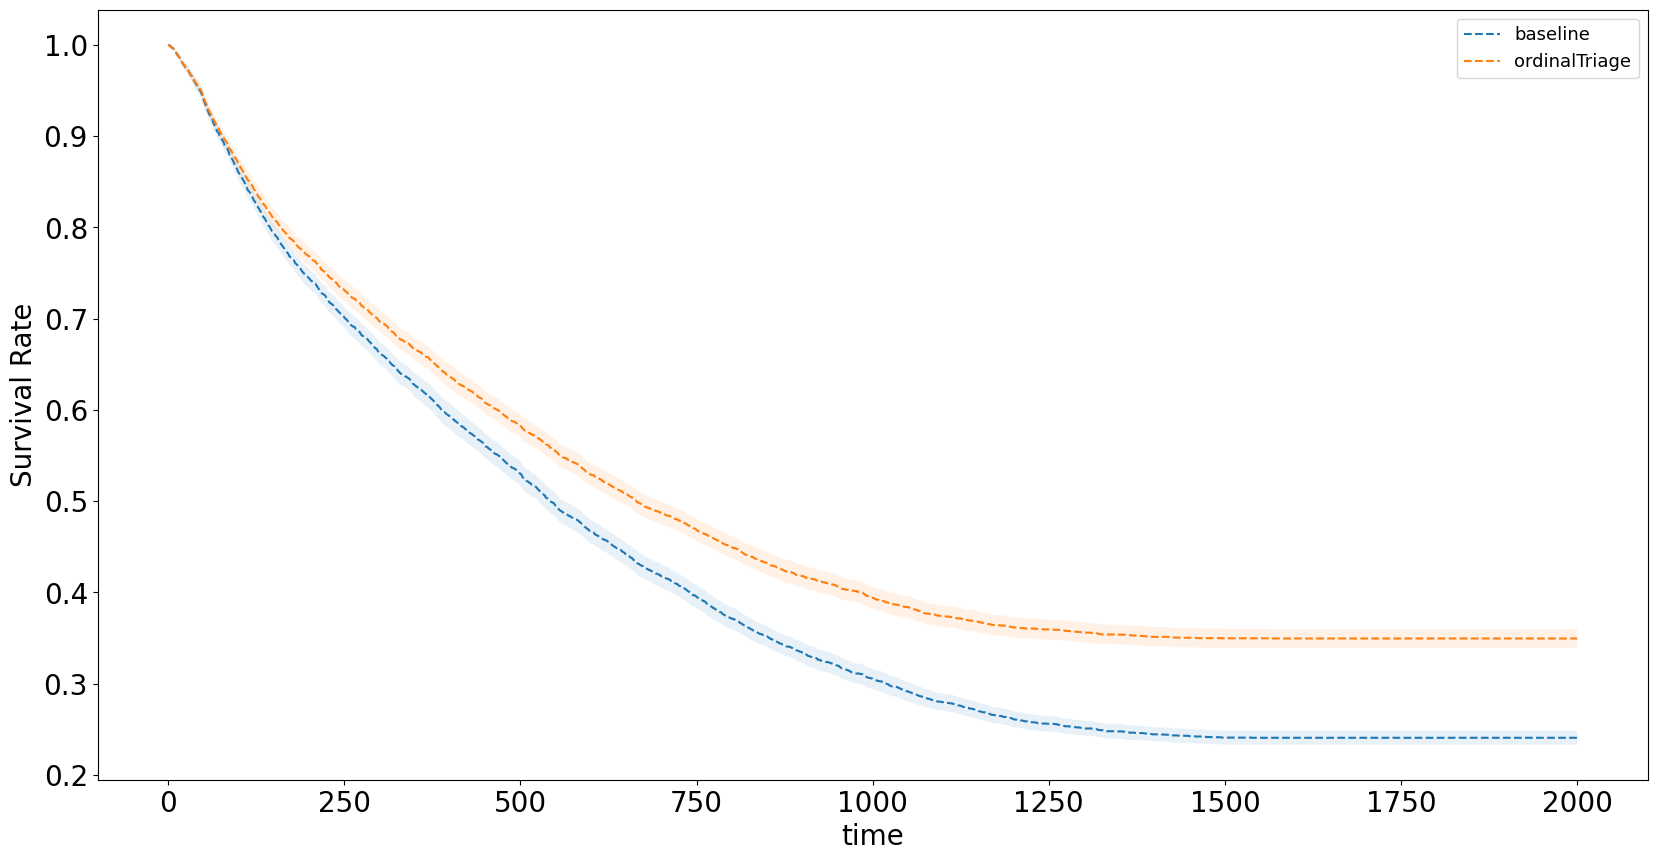

In [ ]:
def experiment1():
    '''
    Compare different policies
    '''
    agents = {'baseline': BaselineAgent,
              'ordinalTriage': OrdinalTriageAgent
            }
    performanceStat = {}
    for name, agent in agents.items():
        print('Policy name:', name)
        performanceStat[name] = simulation(MultiClassMCIEnv, agent, createPaperParameter)
        print("Expected Survival Rate:", str(performanceStat[name]['expectSurvivalRate'][-1]) + "+-" + str(performanceStat[name]['survivalRateHalfWindow'][-1]))
        '''
        meanDiff =  performanceStat['baseline']['expectSurvivalRate'][-1] - performanceStat[name]['expectSurvivalRate'][-1]
        sampleVar1, sampleSize1 = performanceStat['baseline']['survivalRateSampleVariance'][-1], performanceStat['baseline']['sampleSize']
        sampleVar2, sampleSize2 = performanceStat[name]['survivalRateSampleVariance'][-1], performanceStat[name]['sampleSize']
        halfWindow = 1.96 * np.sqrt(sampleVar1/sampleSize1 + sampleVar2/sampleSize2)
        print('Improve:', meanDiff, "+-", halfWindow)
        '''
    return performanceStat
performanceStatPlot(experiment1())

In [ ]:
patients = pd.read_csv('./input/input_4.csv', index_col=0)
ctRoomNumber = 2
orRoomNumber = 1
subClassNumbers = [2, 3, 4]
mciModel =  MultiClassMCIEnv(patients, subClassNumbers, ctRoomNumber, orRoomNumber)
agent = OrdinalTriageAgent(mciModel)
# 2. simulate
state = mciModel.reset()
done = False
info = {'where': {'CT','OR'}}
while not done:
    action = agent.chooseAction(state, info)
    print(state.iloc[38], action)
    state, reward, done, info = mciModel.step(action)
